In [ ]:
# Notebook to develop functions to pick non-square micrographs.
# Test on the proteoliposome dataset.

In [1]:
from vesicle_picker import (
    preprocess,
    generate_masks,
    postprocess,
    helpers,
    external_import,
    external_export,
    funcs_mrcio
)
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

In [4]:
# Define an import function
def import_mrc(filename):
    """Use funcs_mrcio to open a specified .mrc file"""
    # Read the .mrc file in binary
    micrograph = open(filename, 'rb')

    # Use funcs_mrcio to extract image array and
    # rescale values to lie between [-1, 1]
    image = funcs_mrcio.irdsec_opened(micrograph, 0)

    # Use funcs_mrcio to extract header info
    header = funcs_mrcio.irdhdr_opened(micrograph)

    # Return the rescaled image and header
    return image, header

In [98]:
# Import the example mrc
image_fullres, header = import_mrc("/data_8tb/CS-rk-empiar-11637/J2/motioncorrected/000496428492477815180_FoilHole_7497933_Data_7496889_7496891_20220807_183229_fractions_patch_aligned_doseweighted.mrc")

In [99]:
# Use the preprocess module to get micrograph ready for segmentation
preprocessed_micrograph = preprocess.preprocess_micrograph(
    image_fullres,
    downsample=4,
    lowpass_mode="bilateral",
    d=17,
    sigmaColor=71,
    sigmaSpace=71
)

(-0.5, 1022.5, 1439.5, -0.5)

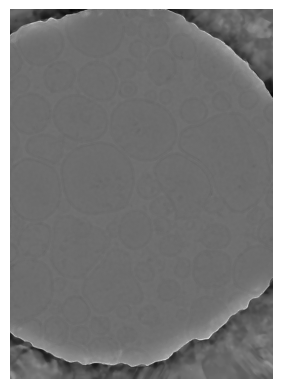

In [100]:
# Display the preprocessed micrograph
plt.imshow(preprocessed_micrograph, cmap="Greys_r")
plt.axis('off')

In [101]:
# Use the generate_masks module to perform automatic image segmentation
# Initialize the model
model = generate_masks.initialize_model(
    model_weights_path="sam_vit_h_4b8939.pth",
    device='cuda:0'
)

In [102]:
# Generate masks with user-optimized parameters
masks = generate_masks.generate_masks(
    preprocessed_micrograph,
    model,
    points_per_side=36,
    points_per_batch=16,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.8,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    crop_nms_thresh=0.1,
    min_mask_region_area=100,
    psize=1.07,
    downsample=4
)

In [103]:
# Use the postprocess module to compute statistics on the vesicles
postprocessed_masks = postprocess.postprocess_masks(
    masks,
    [
        postprocess.find_mask_intensity,
        postprocess.find_contour,
        postprocess.find_roundness,
        postprocess.fit_ellipse
    ],
    preprocessed_micrograph
)

In [104]:
# Filter these vesicles based on min and max values recorded in 'filters.ini'
filtered_masks = postprocess.apply_filters(postprocessed_masks, "tests/filters.ini")

# Use the extract_statistics function to generate Pandas Dataframes
# of the postprocessed values, for downstream analysis.
unfiltered_dataset, filtered_dataset = (
    postprocess.extract_statistics(postprocessed_masks, "tests/filters.ini")
)

pd.DataFrame(filtered_dataset)

,area,roundness,intensity
0,37116,0.884180,-0.046242
1,15129,0.892462,-0.027527
2,32298,0.755897,-0.056546
3,38813,0.830763,-0.017658
4,8940,0.885486,-0.010201
...,...,...,...
56,6282,0.758574,0.313078
57,2759,0.752476,0.000859
58,7925,0.764097,0.267290
59,34176,0.839640,0.133663


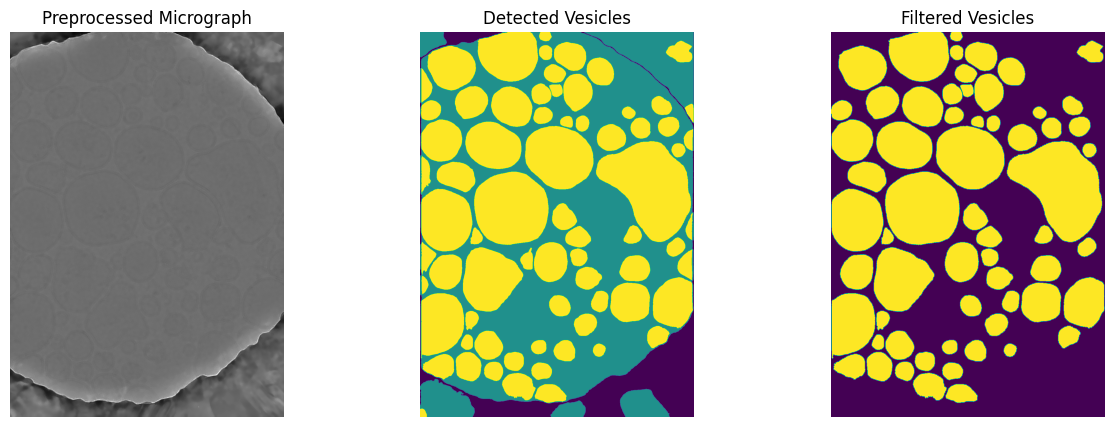

In [105]:
# Create a figure with three subplots arranged in a row
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image in the first subplot
axes[0].imshow(preprocessed_micrograph, cmap="Greys_r")
axes[0].set_title('Preprocessed Micrograph')

# Plot the second image in the second subplot
axes[1].imshow(helpers.sum_masks(masks, 'segmentation'))
axes[1].set_title('Detected Vesicles')

# # Plot the third image in the third subplot
axes[2].imshow(helpers.sum_masks(filtered_masks, 'segmentation'))
axes[2].set_title('Filtered Vesicles')

# Remove axis labels and ticks
for ax in axes:
    ax.axis('off')

In [106]:
# Modify the generate picks function

psize=1.07
downsample=4 
box_size=50 #Angstrom
mode='edge'

"""
Takes masks found by segment-anything and returns evenly spaced
particle picks along the edge or the surface of the object masks.

Arguments:
masks (list): Masks found by segmentation of a micrograph,
with or without postprocessing.
downsample (int): The downsampling factor applied when generating masks.
psize (float): The pixel size of the original micrograph (Angstrom/pixel).
box_size (int): The spacing used to make a grid of picks in
the micrograph, in Angstrom. A larger number represents sparcer picks.
mode (str): Whether to return edge ("edge") or surface picks ("surface").

Outputs:
pick_indices (list): A list of numpy arrays containing the
0th axis and 1st axis indices of particle pick locations,
respectively, upsampled to map back onto the full-resolution micrograph.
"""

# Convert the given box size in Angstrom
# to the closest compatible box size in pixels.
box_size = int(np.round(box_size/(psize*downsample)))

print(box_size)

12


In [107]:
# Generate the composite pick mask
pick_mask = helpers.sum_masks(filtered_masks, 'edge')

In [108]:
# Zero pad the image
h_org = pick_mask.shape[0]
w_org = pick_mask.shape[1]
print(h_org, w_org)
h_pad = int(np.ceil(h_org/box_size)*box_size - h_org)
w_pad = int(np.ceil(w_org/box_size)*box_size - w_org)
print(h_pad, w_pad)

1440 1023
0 9


In [109]:
pick_mask_pad = np.pad(pick_mask, ((0,h_pad),(0,w_pad)), "constant")

In [110]:
pick_mask_pad.shape

(1440, 1032)

In [111]:
# Split the micrograph into evenly spaced grids
split_pick_mask = helpers.blockshaped(pick_mask_pad, box_size, box_size)

In [112]:
# In each patch, if the sum of the mask is greater
# than zero (i.e. if there is an edge)
# select the pick closest to the center by setting all
# other values in the patch to zero
for i in range(split_pick_mask.shape[0]):
    this_patch = np.copy(split_pick_mask[i, :, :])
    if np.sum(this_patch) > 0:
        indices = np.argwhere(this_patch)
        distances = np.sum((indices - box_size / 2) ** 2, axis=1)
        best_indices = indices[np.argmin(distances)]
        this_patch = np.zeros(this_patch.shape)
        this_patch[best_indices[0], best_indices[1]] = 1
        split_pick_mask[i, :, :] = this_patch

In [113]:
# Undo the split
merged_pick_mask_pad = helpers.unblockshaped(
    split_pick_mask,
    pick_mask_pad.shape[0],
    pick_mask_pad.shape[1]
)

In [114]:
# Undo the pad
merged_pick_mask = merged_pick_mask_pad[0:h_org, 0:w_org]

In [115]:
# Generate the pick indices
pick_indices = np.where(merged_pick_mask == 1)

# Map the grid pick indices back to the full-res image
pick_indices = (downsample*pick_indices[0], downsample*pick_indices[1])

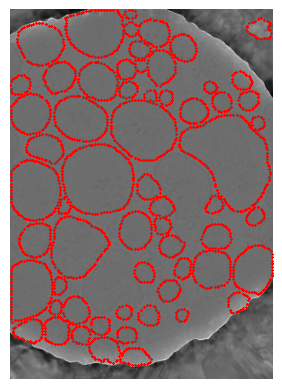

In [117]:
# Plot the preprocessed micrograph with picks overlaid
plot_micrograph = preprocess.preprocess_micrograph(
    image_fullres,
    downsample=4,
    lowpass_mode="bilateral",
    d=11,
    sigmaColor=71,
    sigmaSpace=71
)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.imshow(plot_micrograph, cmap="Greys_r")

# Overlay the undilated picks
ax1.scatter(x=pick_indices[1]/4,
            y=pick_indices[0]/4,
            marker='x',
            color='red',
            s=1,
            label='original')

plt.axis('off')
plt.show()